<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [1]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem
import scipy.stats as stats

import pylab as plt
import seaborn as sns

In [ ]:
# Diseño experimento.
"""
Hacemos un test de dos colas ya que no sabemos si la nueva página funciona mejor o peor.

H0: p = po
H1: p != po

p y po son las tasas de retención de la nueva y vieja versión de la página web. Se establece un intervalo de confianza del 95%
(alfa = 0,05)
"""

In [2]:
# datos
df=pd.read_csv('data/cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
df.version.unique()

array(['gate_30', 'gate_40'], dtype=object)

In [4]:
control = df[df.version=="gate_30"]

In [5]:
tratamiento = df[df.version=="gate_40"]

In [6]:
control.retention_1.value_counts()

False    24666
True     20034
Name: retention_1, dtype: int64

In [7]:
tratamiento.retention_1.value_counts()

False    25370
True     20119
Name: retention_1, dtype: int64

In [8]:
control.retention_7.value_counts()

False    36198
True      8502
Name: retention_7, dtype: int64

In [9]:
tratamiento.retention_7.value_counts()

False    37210
True      8279
Name: retention_7, dtype: int64

In [10]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 7.1 MB


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,90189.0,4.998412e+06,2.883286e+06,116.0,2512230.0,4995815.0,7496452.0,9999861.0
sum_gamerounds,90189.0,5.187246e+01,1.950509e+02,0.0,5.0,16.0,51.0,49854.0


In [14]:
# muestreo
import statsmodels.stats.api as sms
efecto=sms.proportion_effectsize(0.45, 0.55) # No se especifica el efecto del test en el el ejercicio. He puesto un 1%.

efecto

-0.2003348423231197

In [15]:
n_requerido=sms.NormalIndPower().solve_power(efecto,
                                             power=0.8,
                                             alpha=0.05)

n_requerido  # tamaño de la muestra

391.1322551881439

In [16]:
control=control.sample(n=392, random_state=42)

tratamiento=tratamiento.sample(n=392, random_state=42)

ab_test=pd.concat([control, tratamiento], axis=0)

ab_test.reset_index(drop=True, inplace=True)

ab_test.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,6531033,gate_30,35,False,False
1,8003009,gate_30,4,False,False
2,5566807,gate_30,23,True,False
3,64235,gate_30,1,False,False
4,6210551,gate_30,7,False,False


In [17]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          784 non-null    int64 
 1   version         784 non-null    object
 2   sum_gamerounds  784 non-null    int64 
 3   retention_1     784 non-null    bool  
 4   retention_7     784 non-null    bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 20.0+ KB


In [18]:
ab_test.version.value_counts()

gate_30    392
gate_40    392
Name: version, dtype: int64

In [19]:
tasas_conversion=ab_test.groupby('version')['retention_1']

std=lambda x: np.std(x, ddof=0)             # std poblacional
error_std=lambda x: stats.sem(x, ddof=0)    # error estandard (std/sqrt(n))

tasas_conversion=tasas_conversion.agg([np.mean, std, error_std])

tasas_conversion.columns=['conv_rate', 'std', 'error_std']

tasas_conversion.style.format('{:.3f}')

,conv_rate,std,error_std
version,,,
gate_30,0.464,0.499,0.025
gate_40,0.467,0.499,0.025


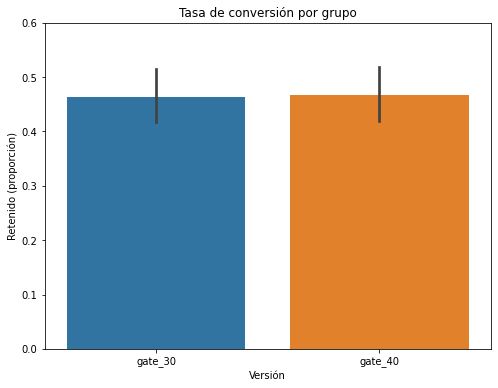

In [28]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['version'], 
            y=ab_test['retention_1'], 
            ci=95 # intervalo de confianza (con el error estandard)
           )

plt.ylim(0, 0.60)
plt.title('Tasa de conversión por grupo')
plt.xlabel('Versión')
plt.ylabel('Retenido (proporción)');

In [29]:
# testeo para retention_1
control_res=ab_test[ab_test.version=='gate_30']['retention_1']
tratamiento_res=ab_test[ab_test.version=='gate_40']['retention_1']

In [30]:
n_con=control_res.count()   # cuenta de elementos por grupo, ie, conversiones
n_trat=tratamiento_res.count()

conversiones=[control_res.sum(), tratamiento_res.sum()]  # conversiones por grupo

observaciones=[n_con, n_trat] # cuenta N de cada grupo

z_score, p_value = proportions_ztest(conversiones, nobs=observaciones)

z_score, p_value

(-0.0715986094296942, 0.9429213467512827)

In [31]:
# intervalos de confianza

(control_a, tratamiento_a), (control_b, tratamiento_b) = proportion_confint(conversiones, 
                                                                           nobs=observaciones,
                                                                           alpha=0.05)

# se definen las dos tuplas de salida del confint

print('Control', [control_a, control_b])
print('Tratamiento', [tratamiento_a, tratamiento_b])

Control [0.4149155773449074, 0.5136558512265211]
Tratamiento [0.41744916240035357, 0.5162243069874015]


In [33]:
# testeo para retention_7
control_res=ab_test[ab_test.version=='gate_30']['retention_7']
tratamiento_res=ab_test[ab_test.version=='gate_40']['retention_7']

In [34]:
n_con=control_res.count()   # cuenta de elementos por grupo, ie, conversiones
n_trat=tratamiento_res.count()

conversiones=[control_res.sum(), tratamiento_res.sum()]  # conversiones por grupo

observaciones=[n_con, n_trat] # cuenta N de cada grupo

z_score, p_value = proportions_ztest(conversiones, nobs=observaciones)

z_score, p_value

(0.7418845589930833, 0.45815728198346883)

In [35]:
(control_a, tratamiento_a), (control_b, tratamiento_b) = proportion_confint(conversiones, 
                                                                           nobs=observaciones,
                                                                           alpha=0.05)

# se definen las dos tuplas de salida del confint

print('Control', [control_a, control_b])
print('Tratamiento', [tratamiento_a, tratamiento_b])

Control [0.15238802740210436, 0.23026503382238542]
Tratamiento [0.13365362933156077, 0.20818310536231677]


In [25]:
# conclusiones
# Explica detalladamente las conclusiones obtenidas de. tu testeo.
"""
Retención 1 día; Las diferencias entre la versión antigua y nueva son mínimas. En principio parece que es 
ligeramente mejor la versión nueva para un intervalo de confianza del 95% aunque no existe una diferencia relevante
entre ambas. No podemos rechazar la H0.

Retención 7 días; Se empeora la retención en la nueva versión si se compara con la antigua.

Se recomienda no implementar la nueva versión.
"""